# Predicting Blood Donations


### **Contents**

---

* [**1. Importing Packages**](#1.-Importing-Packages)
* [**2. Importing Blood Donations Dataset**](#2.-Importing-Blood-Donations-Dataset)
* [**3. Target Feature Considerations**](#3.-Target-Feature-Considerations)
* [**4. Exploring the Dataset**](#4.-Exploring-the-Dataset)
* [**5. Evaluation Metric**](#5.-Evaluation-Metric)
* [**6. Selecting the Algorithms**](#6.-Selecting-the-Algorithms)
* [**7. Optimising the Hyper Parameters**](#7.-Optimising-the-Hyper-Parameters)
* [**8. Evaluating the Test Set**](#8.-Evaluating-the-Test-Set)
* [**9. Evaluating the Full Set**](#9.-Evaluating-the-Full-Set)
* [**10. Conclusions**](#10.-Conclusions)

---

## 1. Importing Packages
---

In [1]:
# File system management
import os

# Numpy and pandas for data analysis and manipulation
import numpy as np
import pandas as pd

# Matplotlib pyplot and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()

# Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Sklearn importing folding methods method
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

# Sklearn importing evaluation metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

# Suppress deprecation warnings
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

# Importing cross validation grid search
from sklearn.model_selection import GridSearchCV

## 2. Importing Blood Donations Dataset

In [2]:
# Setting the directory
os.chdir('C:/Users/jakec/my_projects/predicting-blood-donations')
# Viewing the contained items
os.listdir('.')

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'Case_Study_2_Blood_Donations_Data.xlsx',
 'Data_Scientist_Case_Study_2_Instructions.odt',
 'LICENSE',
 'Predicting Blood Donations.ipynb',
 'README.md']

In [3]:
# Importing as pandas dataframe and displaying the top 5 entries of the blood donations dataset
blood_donations_df = pd.read_excel('Case_Study_2_Blood_Donations_Data.xlsx')
blood_donations_df.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in May 2018
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


## 3. Target Feature Considerations
---

### A penny for my thoughts...

Reading the description of the target variable "...to create a model which will predict the likelihood of a donor donating again from the given data set" initially, makes me think we are looking at an open ended timeframe for donating again (e.g. a prediction over the remainder of their lives). But given some of the limitations in the dataset which include: not knowing the dates of each donation; a maximum period since the first donation of 98 months (~8 years); and not being given the actual dates of past donations it would probably be very difficult and inaccurate to model the probability that they ever donate again. 
Secondly, I considered trying to define a reasonable time period in which, if they are to donate again, they are statistically likely to have done so within. In order to define a satisfactory time period an understanding of the distribution of donations over time for each donor would be required. Given the limited range of features in the provided dataset this would require outside knowledge or information (data). For the purposes of this tech evaluation I'm going to avoid looking into external information or data. This is in order to keep the scope of the problem reasonable.

Therefore, the feature 'whether she/he donated blood in May 2018' will be used as the target variable. This feature will act as a proxy for the probability that donors will give blood in a later 'blood drive month' with similar characteristics. The idea of blood drive months is explained later in section 4 of this analysis when exploring the 'Recency (months)' and 'Time (months)' features. 
The 'blood drive months' do not occur at regular intervals. This requires the strong assumption that the profile of donations in May 2018 is a reasonable approximation of donations in any blood drive month.

## 4. Exploring the Dataset
---

In [4]:
# Splitting the data into training and testing sets
train, test = train_test_split(blood_donations_df, test_size=0.20, random_state=42)

In [5]:
# Quick overview of the features
train.describe()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in May 2018
count,598.000000,598.000000,598.000000,598.000000,598.000000
mean,9.536789,5.638796,1409.698997,34.891304,0.235786
std,8.330153,6.036736,1509.183915,24.849832,0.424844
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.000000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


###### Thoughts:
One point of note is that the target variable has a mean value of 0.238 so a base accuracy of 0.764 can be obtained by predicting no one will donate blood.

#### Exploring the “Total Volume Donated (c.c.)”  feature

In [6]:
# Checking the claim that '“Total Volume Donated (c.c.)” (Monetary) is exactly proportional to the 
# “Number of Donations” (Frequency) with Monetary = 250 * Frequency'
(train['Monetary (c.c. blood)']/train['Frequency (times)']).describe()

count    598.0
mean     250.0
std        0.0
min      250.0
25%      250.0
50%      250.0
75%      250.0
max      250.0
dtype: float64

In [7]:
# As the claim is correct I'm dropping the feature 'Monetary (c.c. blood)' as it contains no additional information
# (100% Correlated with 'Monetary (c.c. blood)')
train = train.drop(['Monetary (c.c. blood)'], axis=1)
test = test.drop(['Monetary (c.c. blood)'], axis=1)
blood_donations_df = blood_donations_df.drop(['Monetary (c.c. blood)'], axis=1)

#### Exploring the 'Recency (months)' feature

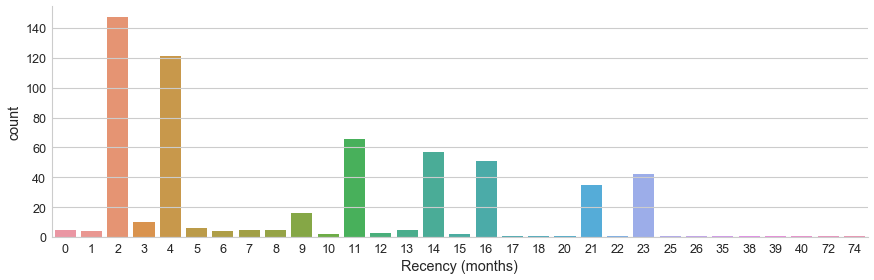

In [8]:
# Quick look at behaviour
sns.catplot('Recency (months)', data = train, kind='count', height=4, aspect=3)

###### Thoughts: 
Over the past 2 years there seems to be a approximate seasonal donation cycle; whereby specific months, year on year, show significant spikes. These spikes are seen in Recency's of 16 (Jan 2017), 14 (Mar 2017) which line up with spikes seen a year later 4 (Jan 2018), 2 (Mar 2018).
However, assuming that a Recency of 0 represents people who donated in May 2018 but not on the 31st. The target variable which shows that 23.7968% of the 748 people donated on 31 May 2018 (a spike) doesn't fit this trend. If it is assumed that these spikes occur on a specific day of the week it could have occured a day later the previous year and therefore June 2017 would represent a spike continuing the trend.
These spikes will be referred to as 'blood drives' for the rest of this analysis as a blood drive would be a reasonable cause of the observed trend.

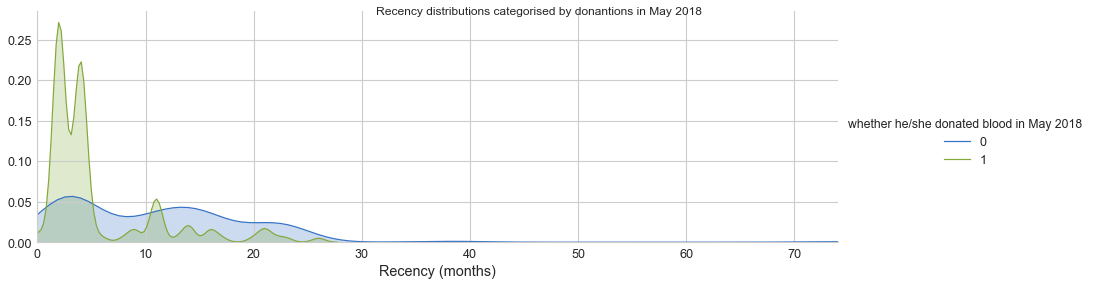

In [9]:
# Plotting the distributions of the recency against donations in May
recency = sns.FacetGrid(train, hue = 'whether he/she donated blood in May 2018', height=4, aspect=3)
recency.map(sns.kdeplot, 'Recency (months)', shade= True)
recency.set(xlim=(0 , train['Recency (months)'].max()))
recency.fig.suptitle('Recency distributions categorised by donantions in May 2018')
recency.add_legend()

###### Thoughts: 
There seems to be an overall decreasing trend for the ratio of donations but there is a lot of overlapping noise.
This could be caused by a larger ratio of donations to non-donations in blood drive months.

#### Exploring the 'Time (months)' (Months since First Donation) feature

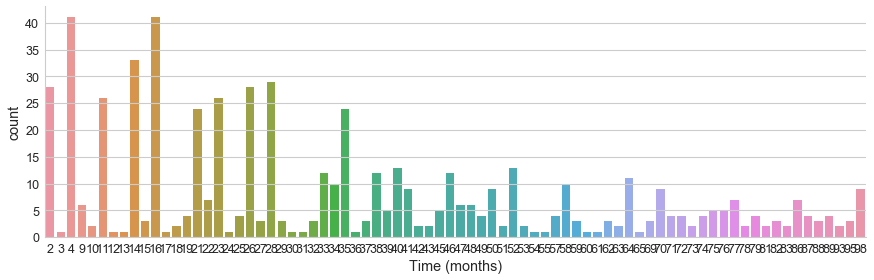

In [10]:
sns.catplot('Time (months)', data = train, kind='count', height=4, aspect=3)

###### Thoughts: 
The year-on-year cycle of blood drives can be seen again in the 'Time (months)' feature.

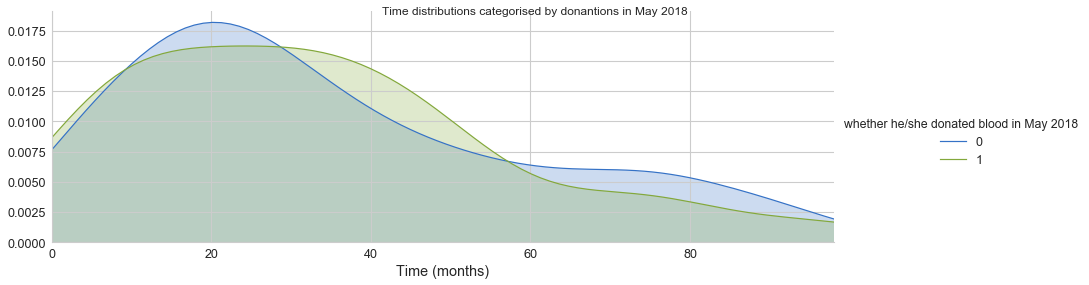

In [11]:
# Plotting the distributions of the time against donations in May
recency = sns.FacetGrid(train, hue = 'whether he/she donated blood in May 2018', height=4, aspect=3)
recency.map(sns.kdeplot, 'Time (months)', shade= True)
recency.set(xlim=(0 , train['Time (months)'].max()))
recency.fig.suptitle('Time distributions categorised by donantions in May 2018')
recency.add_legend()

###### Thoughts: 
The distribution shows a relationship that is not immediately intuitive with 4 distinct sections. Twenty four  to 50 months seems to be the most likely time period after which people are likely to donate again, 0-12 the second most , 50+ the least, 12-23 is the second least. This indicates that, when the time is viewed in isolation, it has a non-monotonic relationship with the target. Care may need to be taken when treating this feature in algorithms such as logistic regressions which treat numeric variables as monotonic. Weight-of-evidence or other binning methods could be used to address this.

#### Exploring the 'Frequency (times)' feature

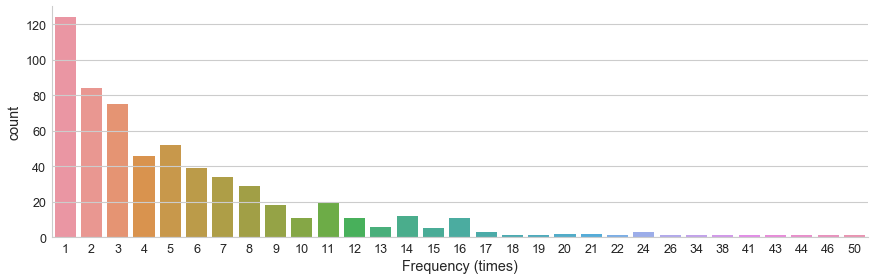

In [12]:
sns.catplot('Frequency (times)', data = train, kind='count', height=4, aspect=3)

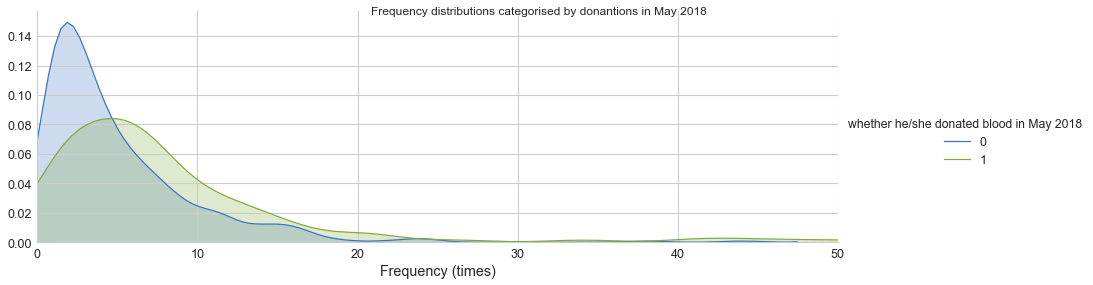

In [13]:
# Plotting the distributions of the frequency against donations in May
recency = sns.FacetGrid(train, hue = 'whether he/she donated blood in May 2018', height=4, aspect=3)
recency.map(sns.kdeplot, 'Frequency (times)', shade= True)
recency.set(xlim=(0 , train['Frequency (times)'].max()))
recency.fig.suptitle('Frequency distributions categorised by donantions in May 2018')
recency.add_legend()

###### Thoughts: 
It's advantageous to have donated more than 5 times but relatively stable after that (It's hard to distinguish after 25 months due to low volumes).

#### Creating and exploring a rate of donations feature

In [14]:
# Defining new feature 'Rate as the average number of donations per month
train['Rate (months)'] = train['Frequency (times)']/train['Time (months)']
train['Rate (months)'] = train['Rate (months)'].round(2)

test['Rate (months)'] = test['Frequency (times)']/test['Time (months)']
test['Rate (months)'] = test['Rate (months)'].round(2)

blood_donations_df['Rate (months)'] = blood_donations_df['Frequency (times)']/blood_donations_df['Time (months)']
blood_donations_df['Rate (months)'] = blood_donations_df['Rate (months)'].round(2)

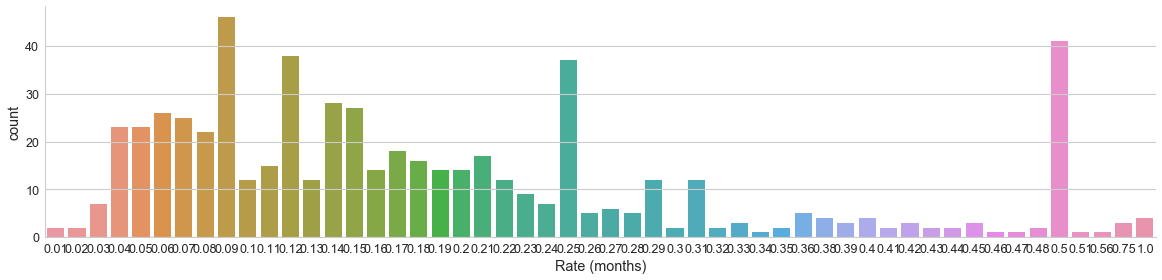

In [15]:
sns.catplot('Rate (months)', data = train, kind='count', height=4, aspect=4)

###### Thoughts:
Higher rates can be seen at 0.25 and 0.5. It is not clear to me if these spikes in the rate of donation are useful at this stage. Also, it might be worth noting that donor rates over 0.5 seems unsafe.

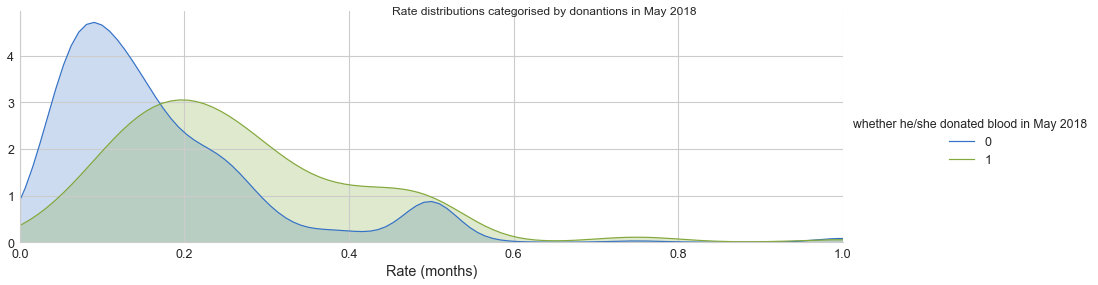

In [16]:
# Plotting the distributions of the rate against donations in May
recency = sns.FacetGrid(train, hue = 'whether he/she donated blood in May 2018', height=4, aspect=3)
recency.map(sns.kdeplot, 'Rate (months)', shade= True)
recency.set(xlim=(0 , train['Rate (months)'].max()))
recency.fig.suptitle('Rate distributions categorised by donantions in May 2018')
recency.add_legend()

###### Thoughts: 
This roughly follows the expected trend, that a lower rate indacates thet donations are less likly. 
There is a notable spike in non-donors with a rate of 0.5 or once every two months. This could be people who donate once every two months and for some reason may is an off month or simply a chance spike. This could use further investigation but for the purposes of this evaluation I'm assuming that the decrease in the ratio of people who donated in May 2018 and donate on average every two months is a chance spike.

#### Creating and exploring a 'On Schedule' feature

In [17]:
# Defining new feature 'On Schedule' as the product of recency to rate (this should quantify if they are currently 
# behind their usual schedule)
train['On Schedule'] = train['Recency (months)']*train['Rate (months)']
train['On Schedule'] = train['On Schedule'].round(1)

test['On Schedule'] = test['Recency (months)']*test['Rate (months)']
test['On Schedule'] = test['On Schedule'].round(1)

blood_donations_df['On Schedule'] = blood_donations_df['Recency (months)']*blood_donations_df['Rate (months)']
blood_donations_df['On Schedule'] = blood_donations_df['On Schedule'].round(1)

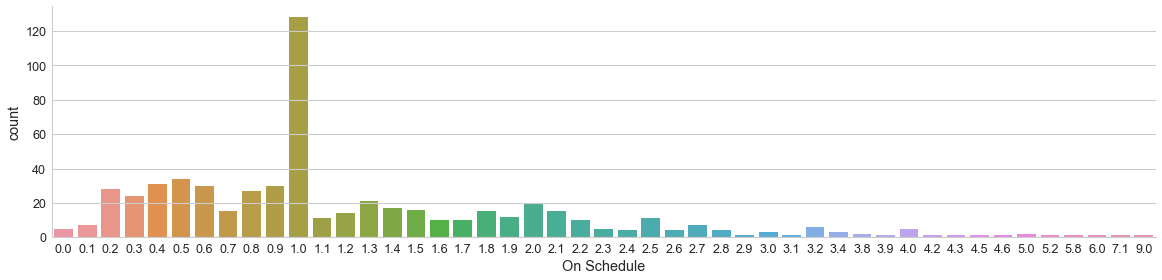

In [18]:
sns.catplot('On Schedule', data = train, kind='count', height=4, aspect=4)

###### Thoughts:
There is a large spike at a schedule of 1. This might be due to people who have only donated once previously.

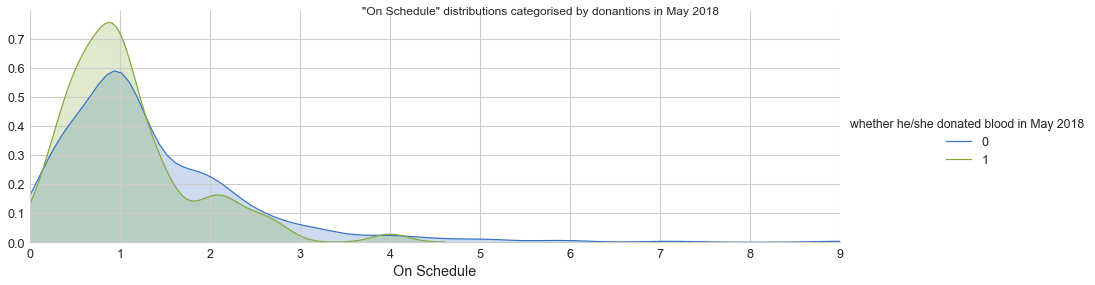

In [19]:
# Plotting the distributions of the rate against donations in May
recency = sns.FacetGrid(train, hue = 'whether he/she donated blood in May 2018', height=4, aspect=3)
recency.map(sns.kdeplot, 'On Schedule', shade= True)
recency.set(xlim=(0 , train['On Schedule'].max()))
recency.fig.suptitle('"On Schedule" distributions categorised by donantions in May 2018')
recency.add_legend()

###### Thoughts: 
There seems to be a reasonably strong relationship for donations around 1.

#### Exploring pair plots and feature correlations

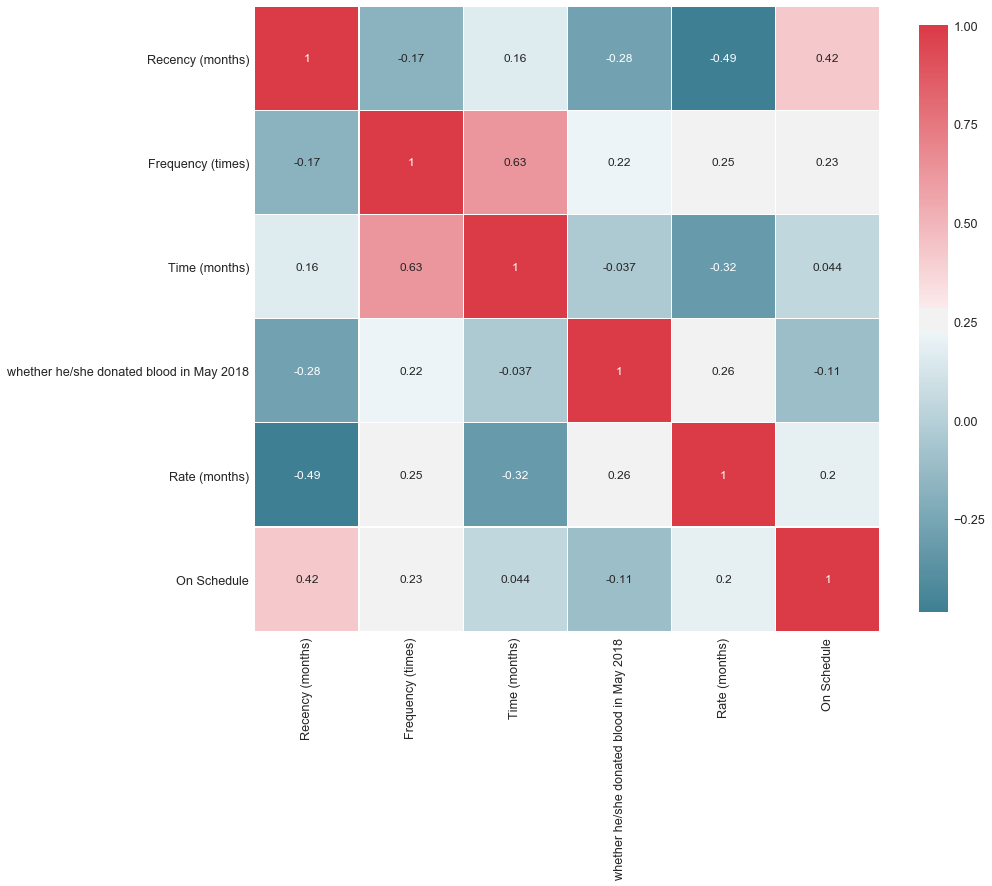

In [20]:
# Correlation heatmap of dataset
corr_plt , ax = plt.subplots(figsize =(14, 12))
colormap = sns.diverging_palette(220, 10, as_cmap = True)

corr_plt = sns.heatmap(
    train.corr(), 
    cmap = colormap,
    square=True, 
    cbar_kws={'shrink':.9 }, 
    ax=ax,
    annot=True, 
    linewidths=0.1,vmax=1.0, linecolor='white',
    annot_kws={'fontsize':12 }
)

##### Thoughts:
A high correlation can be seen between the Rate and Recency features. This is interesting given Rate is not derived from the Recency feature.

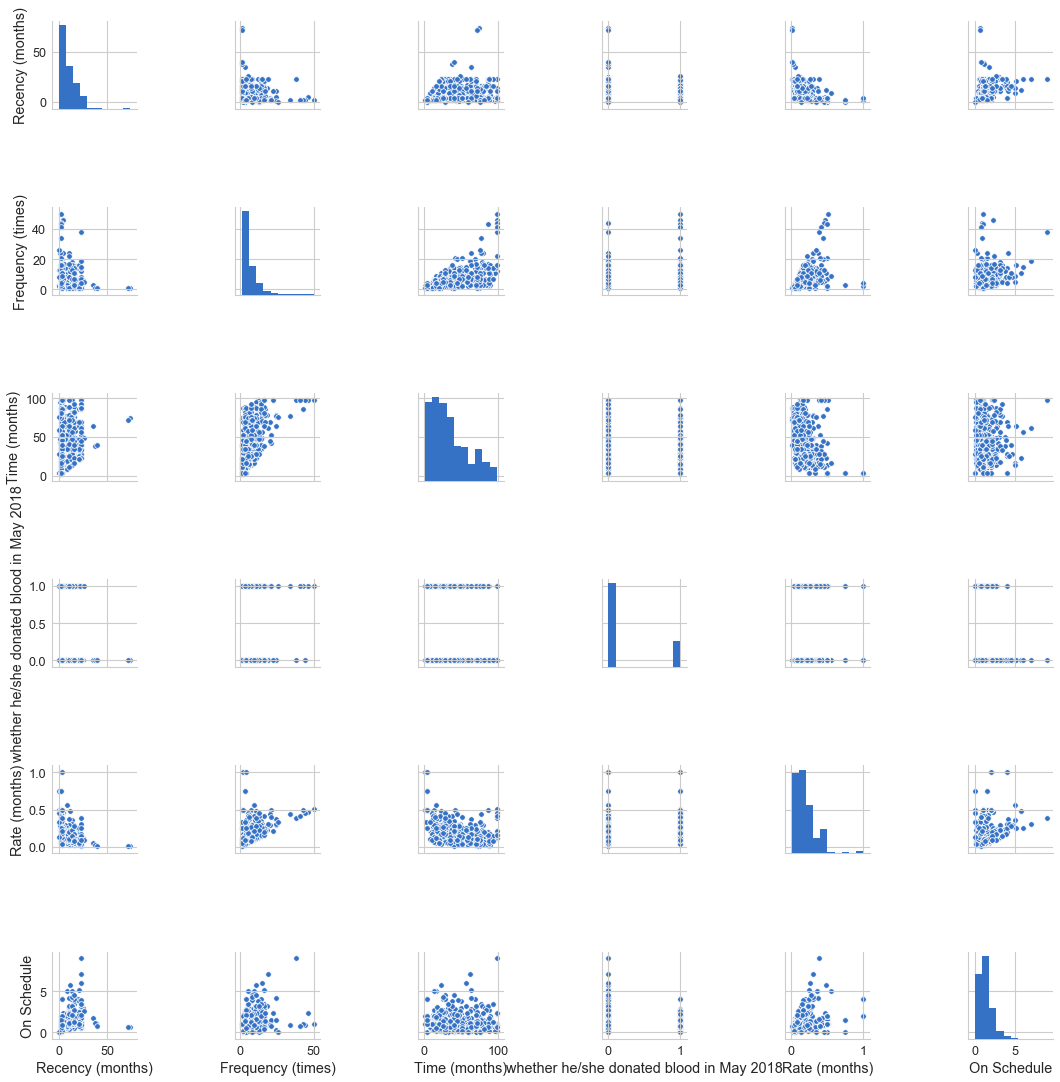

In [21]:
sns.pairplot(train)

#### Dimensionality Reduction:
Due to the simplicity of the dataset (and low correlations) I won't explore the possibility of dimensionality reduction for this evaluation.

#### Normalisation:
I don't expect it to be a large factor in the algorithms as most features are within an order of magnitude. I won't explore normalising features in this evaluation.

#### Additional Engineered Features:
Given the limited time I've spent investigating the data I assume that there other useful insights in various combination or exponential/log features. For the purpose of this eval I will not investigate these further.

## 5. Evaluation Metric
---

###### Thoughts:
The most common and easy to understand metric would be the accuracy. However, because the target variable is somewhat unbalanced maximising accuracy will likely skew the model towards predicting the more common class of non-donors. This could be addressed with with precision-recall analysis. Perhaps a better metric in this case would be the gini or area under the receiver-operating-curve (AUROC). This would measure the model’s ability to order/discriminate likey from unlikely donors. The root-mean-squared-error (RMSE) could be used to make sure that large discrepancies are more heavily penalised then simply using the accuracy (reducing the effect of the imbalance). 
In this case, the Log-Loss will be used as the primary metric while keeping an eye on both, the accuracy and the AUROC. This decision was driven by research into predicting blood donations which revealed that there is an online competition for this (or at least a very similar dataset) that uses log loss an an evaluation metric. The competition describes it as 'This function gives a maximum penalty when an extreme error is made, that is when the actual value is 0 and the predicted value is 1, or vice versa, since it could give an infinity score'. Similarly to the RMSE (except exponentially) this penalises large discrepancies far more then small ones.

## 6. Selecting the Algorithms
---

In [22]:
# Function for displaying feature importance
def display_importances(fld_imp, mdl_nme):
    cols = fld_imp[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = fld_imp.loc[fld_imp.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features (avg over folds)')
    plt.tight_layout()

In [23]:
def model_fit(mdl, mdl_nme = '', n_fld = 5, dbg = True):   
    print(mdl_nme)
    # K fold validation
    fld = StratifiedKFold(n_splits = n_fld, shuffle=True, random_state = 3)
    
    # List of feature columns
    fts = [f for f in train.columns if f not in ['whether he/she donated blood in May 2018']]
    
    # Initializing Variables
    prd = np.zeros(train[fts].shape[0])
    sub_prd = np.zeros(blood_donations_df[fts].shape[0])
    sub_prd_tst = np.zeros(test[fts].shape[0])
    fts_imp = pd.DataFrame()
    acc = 0
    auc = 0
    log_los = 0
    log_los_tot = 0
    
    for n_fold, (trn_idx, vld_idx) in enumerate(fld.split(train[fts], train['whether he/she donated blood in May 2018'])):
        trn_X, trn_y = train[fts].iloc[trn_idx], train['whether he/she donated blood in May 2018'].iloc[trn_idx]
        vld_X, vld_y = train[fts].iloc[vld_idx], train['whether he/she donated blood in May 2018'].iloc[vld_idx]
        
        # Fit the model
        mdl.fit(trn_X, trn_y)
        
        if hasattr(mdl, 'predict_proba'):
            prd[vld_idx] = mdl.predict_proba(vld_X)[:, 1]
            
            # Appling the fit to the prediction set
            sub_prd += mdl.predict_proba(blood_donations_df[fts])[:, 1]/fld.n_splits
            # Appling the fit to the prediction set
            sub_prd_tst += mdl.predict_proba(test[fts])[:, 1]/fld.n_splits
            # Outputting the AUC
            auc += roc_auc_score(vld_y, prd[vld_idx])/fld.n_splits
            log_los = log_loss(vld_y, mdl.predict_proba(vld_X)[:, 1])
            log_los_tot += log_los/fld.n_splits
                
        # Outputting statistics
        print('Fold %2d acc : %.6f' % (n_fold + 1, mdl.score(vld_X, vld_y)))
        print('Fold %2d log_loss : %.6f' % (n_fold + 1, log_los))
        acc += mdl.score(vld_X, vld_y) / fld.n_splits
        
        fld_imp = pd.DataFrame()
        fld_imp["feature"] = fts
        if hasattr(mdl, 'feature_importances_'):
            fld_imp["importance"] = mdl.feature_importances_
        elif hasattr(mdl, 'coef_'):
            fld_imp["importance"] = abs(list(np.std(trn_X, 0))*mdl.coef_[0])
        else:
            fld_imp["importance"] = None
        fld_imp["fold"] = n_fold + 1
        fts_imp = pd.concat([fts_imp, fld_imp], axis=0)
    
    print('Average AUC over folds: %.6f' % auc)
    print('Accuracy : %.6f' % acc)
    print('Average log_loss over folds: %.6f' % log_los)

    # Display Importances and save prediction
    if dbg == False:
        # Displaying Feature Importance
        if (hasattr(mdl, 'feature_importances_') | hasattr(mdl, 'coef_')):
            display_importances(fld_imp, mdl_nme)

    return sub_prd, sub_prd_tst, nme, log_los_tot

#### Initial look at a variety of classification algorithms

In [24]:
MLA = [
   # Ensemble Methods
   ensemble.AdaBoostClassifier(),
   ensemble.BaggingClassifier(),
   ensemble.ExtraTreesClassifier(),
   ensemble.GradientBoostingClassifier(),
   ensemble.RandomForestClassifier(),
       
   # Boosted Tree Classifiers
   XGBClassifier(),  
   LGBMClassifier(),

   # Gaussian Processes
   gaussian_process.GaussianProcessClassifier(),
   
   # GLM
   linear_model.LogisticRegression(),
   linear_model.PassiveAggressiveClassifier(),
   linear_model.RidgeClassifierCV(),
   
   # Navies Bayes
   naive_bayes.BernoulliNB(),
   naive_bayes.GaussianNB(),
   
   # Nearest Neighbor
   neighbors.KNeighborsClassifier(),
   
   # SVM
   svm.SVC(probability=True),
   
   # Trees    
   tree.DecisionTreeClassifier(),
   tree.ExtraTreeClassifier(),
   
   # Discriminant Analysis
   discriminant_analysis.LinearDiscriminantAnalysis(),
   discriminant_analysis.QuadraticDiscriminantAnalysis()
   ]

mdl_dta = pd.DataFrame(columns = ['Algorithm', 'Log Loss'])
row_index = 0

# Applying the algorithms using 5 folds (Not exploring more at this stage) 
for alg in MLA:
   nme = alg.__class__.__name__
   prd, prd_tst, nme, loss = model_fit(alg, mdl_nme = nme, n_fld = 5)
   mdl_dta.loc[row_index, 'Algorithm'] = nme
   mdl_dta.loc[row_index, 'Log Loss'] = loss
   row_index += 1


AdaBoostClassifier
Fold  1 acc : 0.760331
Fold  1 log_loss : 0.671938
Fold  2 acc : 0.766667
Fold  2 log_loss : 0.664546
Fold  3 acc : 0.764706
Fold  3 log_loss : 0.669531
Fold  4 acc : 0.798319
Fold  4 log_loss : 0.671603
Fold  5 acc : 0.781513
Fold  5 log_loss : 0.675067
Average AUC over folds: 0.708822
Accuracy : 0.774307
Average log_loss over folds: 0.675067
BaggingClassifier
Fold  1 acc : 0.768595
Fold  1 log_loss : 2.738574
Fold  2 acc : 0.766667
Fold  2 log_loss : 2.126421
Fold  3 acc : 0.756303
Fold  3 log_loss : 1.647318
Fold  4 acc : 0.756303
Fold  4 log_loss : 1.001636
Fold  5 acc : 0.747899
Fold  5 log_loss : 1.861672
Average AUC over folds: 0.674626
Accuracy : 0.759153
Average log_loss over folds: 1.861672
ExtraTreesClassifier
Fold  1 acc : 0.743802
Fold  1 log_loss : 4.605949
Fold  2 acc : 0.700000
Fold  2 log_loss : 4.636304
Fold  3 acc : 0.739496
Fold  3 log_loss : 3.042566


C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fold  4 acc : 0.773109
Fold  4 log_loss : 2.954719
Fold  5 acc : 0.773109
Fold  5 log_loss : 2.664907
Average AUC over folds: 0.632770
Accuracy : 0.745903
Average log_loss over folds: 2.664907
GradientBoostingClassifier
Fold  1 acc : 0.752066
Fold  1 log_loss : 0.632814
Fold  2 acc : 0.741667
Fold  2 log_loss : 0.526093
Fold  3 acc : 0.789916
Fold  3 log_loss : 0.532403
Fold  4 acc : 0.781513
Fold  4 log_loss : 0.487561
Fold  5 acc : 0.806723
Fold  5 log_loss : 0.545119
Average AUC over folds: 0.697226
Accuracy : 0.774377
Average log_loss over folds: 0.545119
RandomForestClassifier
Fold  1 acc : 0.710744
Fold  1 log_loss : 2.200291
Fold  2 acc : 0.741667
Fold  2 log_loss : 1.346227
Fold  3 acc : 0.731092
Fold  3 log_loss : 1.916009
Fold  4 acc : 0.773109
Fold  4 log_loss : 1.005341
Fold  5 acc : 0.773109
Fold  5 log_loss : 2.117708


C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Average AUC over folds: 0.684992
Accuracy : 0.745944
Average log_loss over folds: 2.117708
XGBClassifier
Fold  1 acc : 0.752066
Fold  1 log_loss : 0.583142
Fold  2 acc : 0.766667
Fold  2 log_loss : 0.479311
Fold  3 acc : 0.756303
Fold  3 log_loss : 0.507145
Fold  4 acc : 0.773109
Fold  4 log_loss : 0.483716
Fold  5 acc : 0.798319
Fold  5 log_loss : 0.551418
Average AUC over folds: 0.719018
Accuracy : 0.769293
Average log_loss over folds: 0.551418
LGBMClassifier
Fold  1 acc : 0.719008
Fold  1 log_loss : 0.649594
Fold  2 acc : 0.750000
Fold  2 log_loss : 0.527606
Fold  3 acc : 0.756303
Fold  3 log_loss : 0.621961
Fold  4 acc : 0.764706
Fold  4 log_loss : 0.604463
Fold  5 acc : 0.739496
Fold  5 log_loss : 0.620443
Average AUC over folds: 0.701090
Accuracy : 0.745902
Average log_loss over folds: 0.620443
GaussianProcessClassifier
Fold  1 acc : 0.710744
Fold  1 log_loss : 0.633547
Fold  2 acc : 0.700000
Fold  2 log_loss : 0.636618
Fold  3 acc : 0.739496
Fold  3 log_loss : 0.606580
Fold  4 a

C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linea

Fold  1 acc : 0.735537
Fold  1 log_loss : 0.000000
Fold  2 acc : 0.783333
Fold  2 log_loss : 0.000000
Fold  3 acc : 0.764706
Fold  3 log_loss : 0.000000
Fold  4 acc : 0.773109
Fold  4 log_loss : 0.000000
Fold  5 acc : 0.756303
Fold  5 log_loss : 0.000000
Average AUC over folds: 0.000000
Accuracy : 0.762598
Average log_loss over folds: 0.000000
RidgeClassifierCV
Fold  1 acc : 0.743802
Fold  1 log_loss : 0.000000
Fold  2 acc : 0.791667
Fold  2 log_loss : 0.000000
Fold  3 acc : 0.781513
Fold  3 log_loss : 0.000000
Fold  4 acc : 0.773109
Fold  4 log_loss : 0.000000
Fold  5 acc : 0.756303
Fold  5 log_loss : 0.000000
Average AUC over folds: 0.000000
Accuracy : 0.769279
Average log_loss over folds: 0.000000
BernoulliNB


C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol pa

Fold  1 acc : 0.752066
Fold  1 log_loss : 0.560903
Fold  2 acc : 0.766667
Fold  2 log_loss : 0.540642
Fold  3 acc : 0.764706
Fold  3 log_loss : 0.540282
Fold  4 acc : 0.764706
Fold  4 log_loss : 0.545780
Fold  5 acc : 0.756303
Fold  5 log_loss : 0.555540
Average AUC over folds: 0.503870
Accuracy : 0.760889
Average log_loss over folds: 0.555540
GaussianNB
Fold  1 acc : 0.702479
Fold  1 log_loss : 0.715767
Fold  2 acc : 0.758333
Fold  2 log_loss : 0.527563
Fold  3 acc : 0.781513
Fold  3 log_loss : 0.581621
Fold  4 acc : 0.739496
Fold  4 log_loss : 0.522486
Fold  5 acc : 0.714286
Fold  5 log_loss : 0.926552
Average AUC over folds: 0.726623
Accuracy : 0.739221
Average log_loss over folds: 0.926552
KNeighborsClassifier
Fold  1 acc : 0.776860
Fold  1 log_loss : 1.837846
Fold  2 acc : 0.766667
Fold  2 log_loss : 1.814451
Fold  3 acc : 0.781513
Fold  3 log_loss : 2.378601
Fold  4 acc : 0.798319
Fold  4 log_loss : 2.650831
Fold  5 acc : 0.739496
Fold  5 log_loss : 2.417444
Average AUC over fold

C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fold  2 acc : 0.750000
Fold  2 log_loss : 0.543039
Fold  3 acc : 0.773109
Fold  3 log_loss : 0.521064
Fold  4 acc : 0.773109
Fold  4 log_loss : 0.504227


C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fold  5 acc : 0.781513
Fold  5 log_loss : 0.515376
Average AUC over folds: 0.637139
Accuracy : 0.761001
Average log_loss over folds: 0.515376
DecisionTreeClassifier
Fold  1 acc : 0.710744
Fold  1 log_loss : 8.411324
Fold  2 acc : 0.700000
Fold  2 log_loss : 9.292739
Fold  3 acc : 0.689076
Fold  3 log_loss : 9.405800
Fold  4 acc : 0.731092
Fold  4 log_loss : 8.484500
Fold  5 acc : 0.731092
Fold  5 log_loss : 7.102418
Average AUC over folds: 0.590382
Accuracy : 0.712401
Average log_loss over folds: 7.102418
ExtraTreeClassifier
Fold  1 acc : 0.685950
Fold  1 log_loss : 9.266553
Fold  2 acc : 0.666667
Fold  2 log_loss : 10.444031
Fold  3 acc : 0.739496
Fold  3 log_loss : 7.379878
Fold  4 acc : 0.756303
Fold  4 log_loss : 7.910599
Fold  5 acc : 0.739496
Fold  5 log_loss : 6.799516
Average AUC over folds: 0.583414
Accuracy : 0.717582
Average log_loss over folds: 6.799516
LinearDiscriminantAnalysis
Fold  1 acc : 0.735537
Fold  1 log_loss : 0.555312
Fold  2 acc : 0.791667
Fold  2 log_loss : 0.

Text(0, 0.5, 'Algorithm')

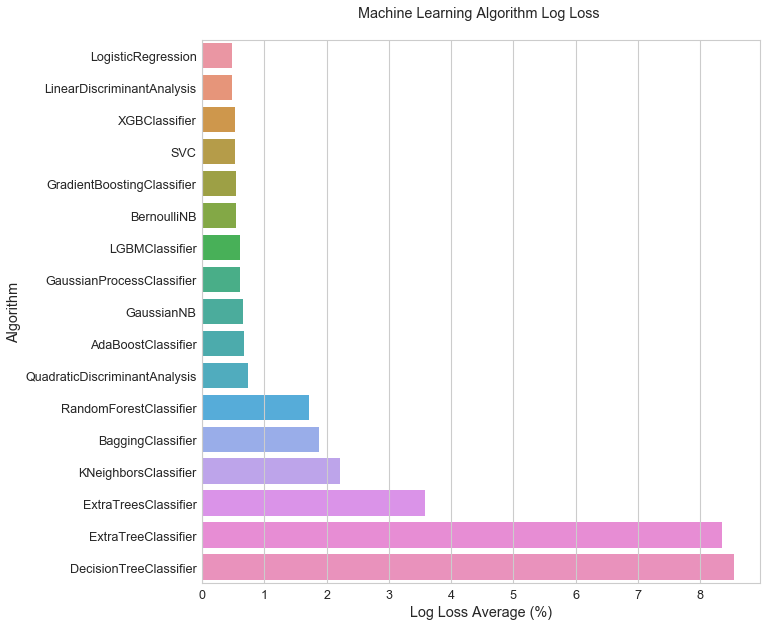

In [25]:
# Plotting algoritims log loss averaged across the folds
plt.figure(figsize=(10,10))
sns.barplot(x='Log Loss', y = 'Algorithm', data = mdl_dta[mdl_dta['Log Loss']>0].sort_values(by='Log Loss'))
plt.title('Machine Learning Algorithm Log Loss \n')
plt.xlabel('Log Loss Average (%)')
plt.ylabel('Algorithm')

##### Thoughts:
Since some of the methods do not have a predict_proba method and so couldn't produce a log_loss or AUC metric, no effort was made to address this shortcoming. The algorithm’s accuracies didn't suggest that they were likely to stand out. While it would be worth investigating these methods in more detail (and possibly a wider range of methods) for the purposes of this evaluation, I will proceed with a selection of the best performing methods. These are: Linear Discriminant Analysis with a log loss of 0.524955; the Support Vector Classification with an radial basis function = 0.517178; the Logistic Regression = 0.529799; and the XGBClassifier = 0.551418.

## 7. Optimising the Hyper Parameters
---

##### Thoughts:
I’m using a basic grid search over a very simple range of parameters; this would benefit from further investigation. 
The small size of the data means that more complex bayesian optimization methods are probably unnecessary.

#### Linear Discriminant Analysis

Linear Discriminant Analysis
Fold  1 acc : 0.735537
Fold  1 log_loss : 0.555312
Fold  2 acc : 0.791667
Fold  2 log_loss : 0.430884
Fold  3 acc : 0.806723
Fold  3 log_loss : 0.435439
Fold  4 acc : 0.781513
Fold  4 log_loss : 0.470212
Fold  5 acc : 0.756303
Fold  5 log_loss : 0.524955
Average AUC over folds: 0.743149
Accuracy : 0.774348
Average log_loss over folds: 0.524955


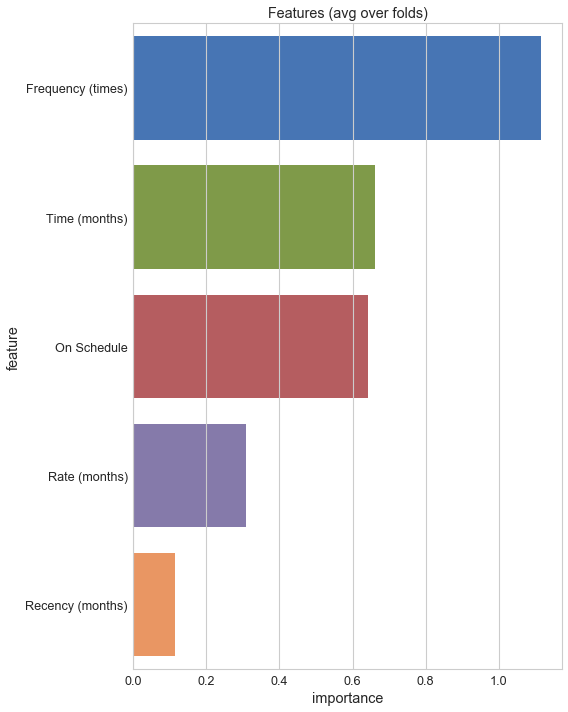

In [26]:
# Linear Discriminant Analysis is closed form and therefore, has no hyper paramaters
LDA = discriminant_analysis.LinearDiscriminantAnalysis()
prd, prd_tst, nme, acc = model_fit(LDA, 'Linear Discriminant Analysis' , n_fld = 5, dbg=False)

#### Support Vector Classifier

In [64]:
# Parameter grid for XGBoost
params =[{
        'gamma': [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2],
        'kernel': ['linear']},
         {
        'C': [0.1, 0.5, 0.8, 1, 1.2, 1.4, 1.6],
        'gamma': [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2],
        'kernel': ['rbf']
        }]

In [65]:
# Fitting the paramater grid
fts = [f for f in train.columns if f not in ['whether he/she donated blood in May 2018']]

search2 = GridSearchCV(estimator = svm.SVC(probability=True, C=0.1, gamma=1, kernel='rbf'), 
                        param_grid = params, scoring='neg_log_loss', n_jobs=8, iid=False, cv=5, 
                        verbose=1)

search2.fit(train[fts],train['whether he/she donated blood in May 2018'])

search2.best_params_, search2.best_score_

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 265 out of 280 | elapsed:    6.5s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:    6.7s finished


({'C': 1.2, 'gamma': 0.01, 'kernel': 'rbf'}, -0.5025754572040321)

In [33]:
SVC = svm.SVC(probability=True, C=1.2, gamma=0.01, kernel='rbf')
prd, prd_tst, nme, acc = model_fit(SVC, 'Support Vector Classifier' , n_fld = 5, dbg=False)
# Note that I expect to see a decrease going to the Average log_loss over folds from the log loss in the optimisation

Support Vector Classifier
Fold  1 acc : 0.760331
Fold  1 log_loss : 0.544428
Fold  2 acc : 0.791667
Fold  2 log_loss : 0.491239
Fold  3 acc : 0.789916
Fold  3 log_loss : 0.512470
Fold  4 acc : 0.806723
Fold  4 log_loss : 0.490594
Fold  5 acc : 0.781513
Fold  5 log_loss : 0.492476
Average AUC over folds: 0.686161
Accuracy : 0.786030
Average log_loss over folds: 0.492476


#### Logistic Regression

In [55]:
# Parameter grid for Logistic Regression
params = {'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}

In [61]:
# Fitting the paramater grid
fts = [f for f in train.columns if f not in ['whether he/she donated blood in May 2018']]

search3 = GridSearchCV(estimator = linear_model.LogisticRegression(C=1)
                      , param_grid = params, scoring='neg_log_loss', n_jobs=8, iid=False, cv=5
                      , verbose=1)

search3.fit(train[fts],train['whether he/she donated blood in May 2018'])

search3.best_params_, search3.best_score_

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  55 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  55 out of  55 | elapsed:    0.1s finished
C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


({'C': 0.01}, -0.4831636069084717)

Logistic Regression
Fold  1 acc : 0.752066
Fold  1 log_loss : 0.536648
Fold  2 acc : 0.800000
Fold  2 log_loss : 0.423201
Fold  3 acc : 0.806723
Fold  3 log_loss : 0.438185
Fold  4 acc : 0.773109
Fold  4 log_loss : 0.458432
Fold  5 acc : 0.756303
Fold  5 log_loss : 0.526230
Average AUC over folds: 0.747398
Accuracy : 0.777640
Average log_loss over folds: 0.526230


C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jakec\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linea

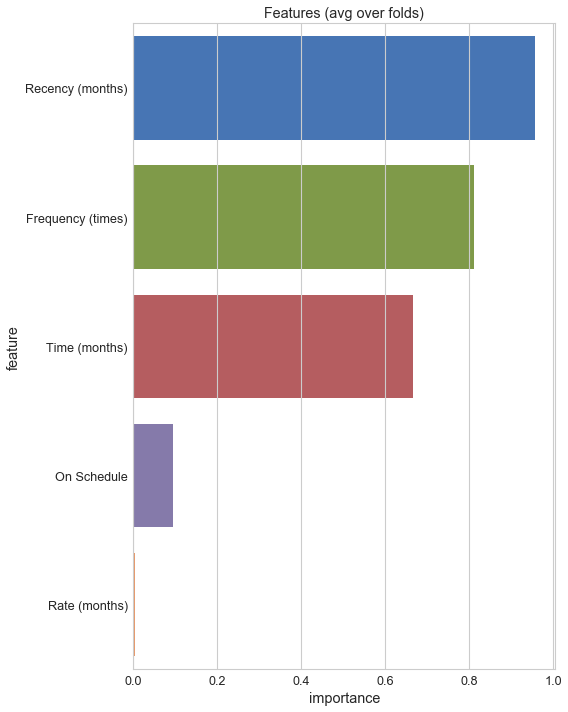

In [40]:
log_reg = linear_model.LogisticRegression(C=0.01)
prd, prd_tst, nme, acc = model_fit(log_reg, 'Logistic Regression' , n_fld = 5, dbg=False)

#### XGBoost Classifier

In [47]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 2, 5, 8, 9, 10, 11, 15, 20],
        'gamma': [0.1, 0.5, 1, 1.5, 2, 4, 6, 10],
        'subsample': [0.2, 0.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
        'max_depth': [1, 2, 3, 4, 5]
        }

In [48]:
# Fitting the paramater grid
fts = [f for f in train.columns if f not in ['whether he/she donated blood in May 2018']]

search1 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, 
                                                  colsample_bytree=0.8, seed=42), 
                        param_grid = params, scoring='neg_log_loss', n_jobs=8, iid=False, cv=5, verbose=1)

search1.fit(train[fts],train['whether he/she donated blood in May 2018'])

search1.best_params_, search1.best_score_

Fitting 5 folds for each of 9000 candidates, totalling 45000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1480 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 3480 tasks      | elapsed:   31.0s
[Parallel(n_jobs=4)]: Done 6280 tasks      | elapsed:   59.9s
[Parallel(n_jobs=4)]: Done 9880 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 14280 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 19480 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 25480 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 32280 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 39880 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done 45000 out of 45000 | elapsed:  8.7min finished


({'colsample_bytree': 1.0,
  'gamma': 4,
  'max_depth': 3,
  'min_child_weight': 2,
  'subsample': 0.8},
 -0.46178167638061485)

XGBClassifier
Fold  1 acc : 0.768595
Fold  1 log_loss : 0.544000
Fold  2 acc : 0.800000
Fold  2 log_loss : 0.432665
Fold  3 acc : 0.815126
Fold  3 log_loss : 0.454831
Fold  4 acc : 0.773109
Fold  4 log_loss : 0.448045
Fold  5 acc : 0.789916
Fold  5 log_loss : 0.469783
Average AUC over folds: 0.758211
Accuracy : 0.789349
Average log_loss over folds: 0.469783


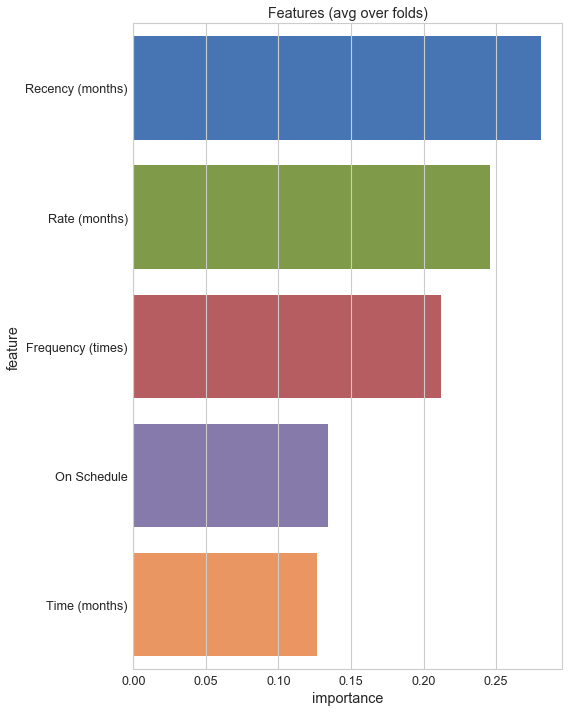

In [54]:
XGB = XGBClassifier(max_depth=3, min_child_weight=2, gamma=4, subsample=0.8, colsample_bytree=0.8, seed=42)
prd, prd_tst, nme, acc = model_fit(XGB, 'XGBClassifier' , n_fld=5, dbg=False)

##### Thoughts:
The XGB Classifier performed the best and so will be used going forwards. However, it is worth noting that, as the XGB is a fairly complex ensemble, other methods which are easier to understand and more readily auditable, may be more desirable. 
If performance is the goal, when developing this model further, the possibility of an ensemble of multiple algorithms should be explored. The difference in the feature importance profiles suggests that the models are relatively uncorrelated. In which case this would be a promising option. 

## 8. Evaluating the Test Set
---

In [66]:
# Outputting the AUROC the Accuracy and the Log Loss statistics
Test_AUC = roc_auc_score(test['whether he/she donated blood in May 2018'], prd_tst)
prd_tst_bin = np.zeros(prd_tst.shape[0])
prd_tst_bin[prd_tst > 0.5] = 1
Test_accuracy = accuracy_score(test['whether he/she donated blood in May 2018'], prd_tst_bin)
Test_log_loss = log_loss(test['whether he/she donated blood in May 2018'], prd_tst)

print('AUC : %.6f' % Test_AUC)
print('Acc : %.6f' % Test_accuracy)
print('Log Loss : %.6f' % Test_log_loss)

AUC : 0.735948
Acc : 0.780000
Log Loss : 0.492305


## 9. Evaluating the Full Set
---

In [67]:
# Outputting the AUROC the Accuracy and the Log Loss statistics
AUC = roc_auc_score(blood_donations_df['whether he/she donated blood in May 2018'], prd)
prd_bin = np.zeros(prd.shape[0])
prd_bin[prd > 0.5] = 1
Accuracy = accuracy_score(blood_donations_df['whether he/she donated blood in May 2018'], prd_bin)
Log_loss = log_loss(blood_donations_df['whether he/she donated blood in May 2018'], prd)

print('AUROC : %.6f' % AUC)
print('Accuracy : %.6f' % Accuracy)
print('Log Loss : %.6f' % Log_loss)

AUROC : 0.803272
Accuracy : 0.808824
Log Loss : 0.436036


#### Refitting the model on the entire dataset (to maximise data for the final fit)

In [68]:
# Resetting main dataset and refitting the model based on the full set to maximise data (This assumes that as the test set showed the model didn't materially overfit)
blood_donations_df = pd.read_excel('Case_Study_2_Blood_Donations_Data.xlsx')
blood_donations_df = blood_donations_df.drop(['Monetary (c.c. blood)'], axis=1)

blood_donations_df['Rate (months)'] = blood_donations_df['Frequency (times)']/blood_donations_df['Time (months)']
blood_donations_df['Rate (months)'] = blood_donations_df['Rate (months)'].round(2)

blood_donations_df['On Schedule'] = blood_donations_df['Recency (months)']*blood_donations_df['Rate (months)']
blood_donations_df['On Schedule'] = blood_donations_df['On Schedule'].round(1)

train =  blood_donations_df
test = blood_donations_df

XGBClassifier
Fold  1 acc : 0.786667
Fold  1 log_loss : 0.493252
Fold  2 acc : 0.786667
Fold  2 log_loss : 0.501885
Fold  3 acc : 0.820000
Fold  3 log_loss : 0.428938
Fold  4 acc : 0.812081
Fold  4 log_loss : 0.502505
Fold  5 acc : 0.778523
Fold  5 log_loss : 0.474096
Average AUC over folds: 0.734974
Accuracy : 0.796787
Average log_loss over folds: 0.474096


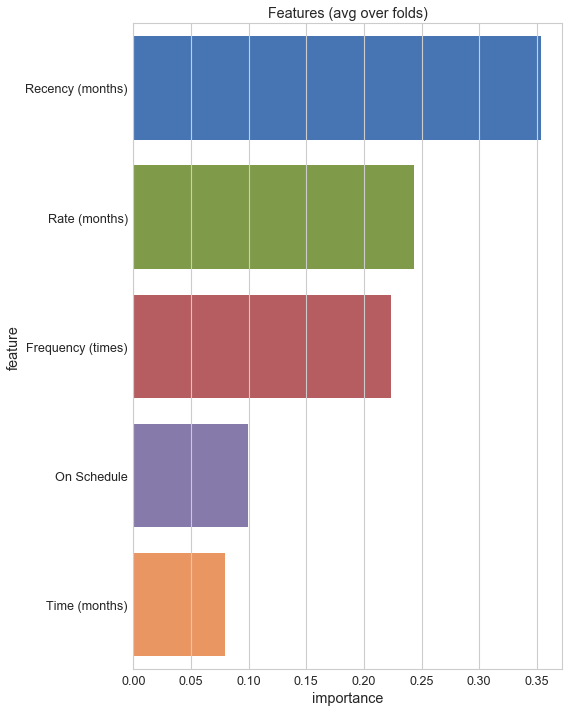

In [69]:
XGB = XGBClassifier(max_depth=3, min_child_weight=9, gamma=1, subsample=1, colsample_bytree=1, seed=42)
prd, prd_tst, nme, acc = model_fit(XGB, 'XGBClassifier', n_fld = 5, dbg=False)

In [70]:
# Outputting the AUROC the Accuracy and the Log Loss statistics
AUC = roc_auc_score(blood_donations_df['whether he/she donated blood in May 2018'], prd)
prd_bin = np.zeros(prd.shape[0])
prd_bin[prd > 0.5] = 1
Accuracy = accuracy_score(blood_donations_df['whether he/she donated blood in May 2018'], prd_bin)
Log_loss = log_loss(blood_donations_df['whether he/she donated blood in May 2018'], prd)

print('AUC : %.6f' % AUC)
print('Acc : %.6f' % Accuracy)
print('Log Loss : %.6f' % Log_loss)

AUC : 0.805697
Acc : 0.812834
Log Loss : 0.431892


#### Plotting the confusion matrix

In [71]:
# Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.figure(figsize=(10,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<Figure size 432x288 with 0 Axes>

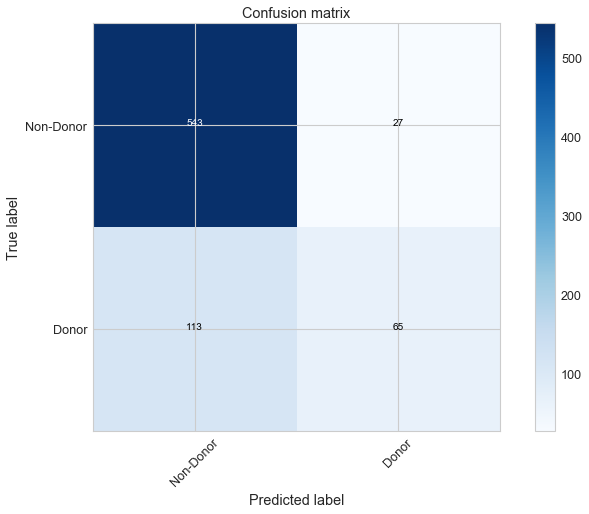

In [72]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(blood_donations_df['whether he/she donated blood in May 2018'], prd_bin)
# np.set_printoptions(precision=2)

class_names = ['Non-Donor', 'Donor']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

##### Thoughts:
As expected with an ensemble algorithm, they tend to under-predict the less common class (people who donated in May 2018). If this is a particularly undesirable outcome, methods such as a logistic regression will give a more realistic split between the classes.

#### Plotting the ROC curve

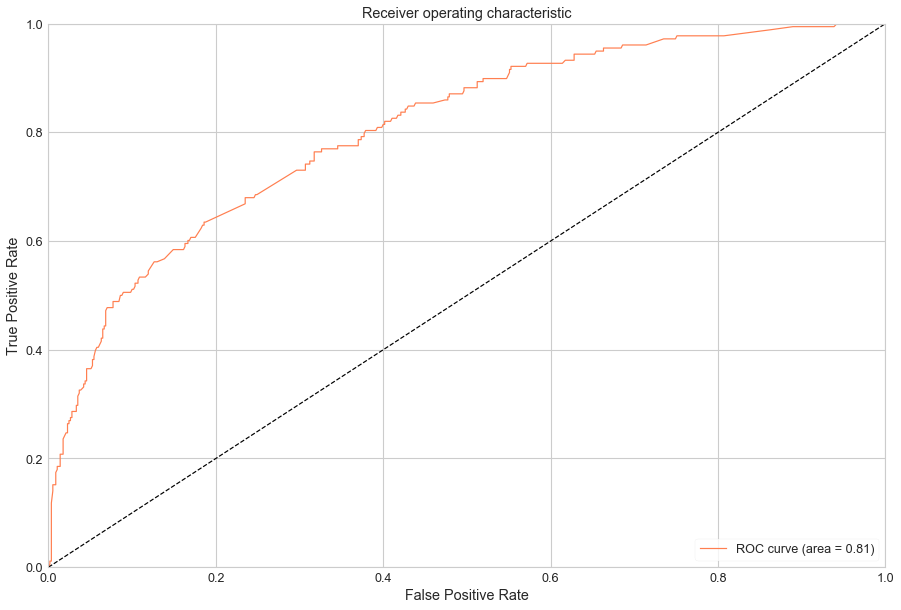

In [73]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(blood_donations_df['whether he/she donated blood in May 2018'], prd)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

##### Thoughts:
Overall the ROC curve indicates a strong ability to distinguish accounts across the board with no weak sections.

## 10. Conclusions
---

For the sake of keeping the problem tractable, the definition of the target variable used in this analysis is the feature 'whether he/she donated blood in May 2018'. This target is only an approximation used to represent the likelihood of donating again in a future month and depends on a range of factors including: is the month the model is applied to (is it a blood-drive month?), and time since the previous blood drive month. If the goal is to build a model to predict the open-ended target 'will they donate again', this is probably a crude approximation at best and is likely to significantly underestimate the probability.

That being said, when assessing the model’s ability to predict the assumed target variable, the model produces a relatively robust set of statistics, when compared to similar models uploaded for DrivenData's competition (https://www.drivendata.org/competitions/2/warm-up-predict-blood-donations). It produced a log loss of 0.43 and 0.49 (on the full and set respectivly), an AUROC of 0.81 and 0.74 and an accuracy of 0.81 and 0.78. When interpreting the ROC curve, there is an indication that the model has a strong ability to distinguish likely from unlikely donors across the entire dataset. 

A limitation on the model can be identified in the confusion matrix which shows that the model is biased towards non-donors. Therefore, if the purpose of the model is to be used to predict anything other then a single donor it will be inaccurate.

Although it is difficult to draw general conclusions from such a limited exploration of the dataset, a number of insights can be gained.
There seems to be a very definite pattern of months with a significant number of donors and months with a limited number of donors. This pattern of blood drive months repeats around the same time each year but becomes noisy after the most recent 28 months.
No standout algorithm was identified in this investigation and a range of different classifiers showed reasonable performance. As such the choice of algorithm may come down to other factors such as simplicity or stability in which case the XGBClassifier would probably be undesirable.

I expect that there is room to improve on the model’s overall performance through further investigating and refining the engineered feature set and optimising the algorithm. There would be significantly more room to improve with a more indepth dataset.